In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd

In [4]:
class Extracting_ERA5Data():
    def __init__(self, path_nc, path_basin):
        self.ds = xr.open_dataset(path_nc, decode_times=True)
        self.grid_size = 0.25
        self.path_basin = path_basin
        self.timestep = self.ds['t2m'].values.shape[0]
        self.datetime_series = pd.Series(self.ds['time'][0:self.timestep])
        self.datetime_series = np.array(self.datetime_series, dtype=object)
        self.longitudes = self.ds["longitude"].values
        self.len_long = len(self.longitudes)
        self.latitudes = self.ds["latitude"].values
        self.len_lat = len(self.latitudes)

        self.gdf = gpd.read_file(self.path_basin)
        self.geometries = self.gdf["geometry"]
        self.subbasin_name = self.gdf["name"]  
        # it may not match for all type of basins. you may need to change this.

    # finding all the point locations that are within  the boundaries
    def find_center_of_data_grid(self):
        points = []
        for lon in self.longitudes:
            for lat in self.latitudes:
                points.append((lon, lat))
        lat_long = np.array(points).reshape((self.len_lat, self.len_long, 2))
        return lat_long
    
    # extracting point from basin shape file (just used for plotting)
    def extract_points_of_basins(self):
        points_of_shape_file = np.empty((0,  2))
        number_of_points_in_each_polygon = []
        for geometry in self.geometries:
            if geometry.geom_type == 'Polygon':
                points_one_polygon = np.array(geometry.exterior.coords[:])
                self.number_of_points_in_each_polygon.append(len(points_one_polygon))
                points_of_shape_file = np.concatenate((points_of_shape_file, points_one_polygon), axis=0)
                
            elif geometry.geom_type == 'MultiPolygon':
                # number_points_multi_polygon = []
                for polygon in geometry.geoms:
                    points_one_polygon = np.array(polygon.exterior.coords[:])
                    # number_points_multi_polygon.append(len(points_one_polygon))
                    points_of_shape_file = np.concatenate((self.points_of_shape_file, points_one_polygon), axis=0)

                    number_of_points_in_each_polygon.append(len(points_one_polygon))
                    # number_of_points_in_each_polygon.append(sum(number_points_multi_polygon))

        number_of_points_in_each_polygon = [sum(self.number_of_points_in_each_polygon[:i+1]) for i in range(len(self.number_of_points_in_each_polygon))]  # cumulative sum
        return number_of_points_in_each_polygon, points_of_shape_file
    
    # creating rectangle around the data points
    def create_rect(self, point, diff):
        return (
            [point[0] - diff, point[1] + diff],
            [point[0] + diff, point[1] + diff],
            [point[0] + diff, point[1] - diff],
            [point[0] - diff, point[1] - diff],
        )

    # here is the flaw. I have increase the coordinate by 0.25 degree, because grid size is 0.25 degree. but in other cases grid may not 0.25 degree. 
    # And also ther may be irregular grid size. 
    # And also this portion of the code should be re-considered later.  
    # this is the easiest code. But this is where i was stuck. I wonder why?
    def create_rect_around_c_data(self):
        lat_long = self.find_center_of_data_grid()
        rects = []
        for point in lat_long.reshape(-1, 2):
            rects.append(list(self.create_rect(point, self.grid_size / 2)))
        rects = np.array(rects)
        rects = rects.reshape(self.len_lat, self.len_long, 4, 2)
        return rects
    
    def find_area_between_polygon(self, polygon1, polygon2):
        intersection = polygon1.intersection(polygon2)
        return intersection.area
    
    # this function looks very big. i should try to divide this into some component.
    def extract_variable(self, var_name):
        rects = self.create_rect_around_c_data()
        one_basin_var = np.zeros((self.timestep, 1))
        all_basins_var = self.datetime_series.reshape((-1, 1))

        if var_name == 't2m':
            var_matrix = self.ds[var_name].values - 273.15
        else:
            var_matrix = self.ds[var_name].values * 1000  

        if len(var_matrix.shape) == 3:
            pass
        elif len(var_matrix.shape) == 4:
            var_matrix = var_matrix[~np.isnan(var_matrix)].reshape((self.timestep, self.len_lat, self.len_long)) # remove all the nan values and reduced the expver dimension

        # find the var of all the sub-basins
        for geometry, name in zip(self.geometries, self.subbasin_name):
            print(name)
        # find the var of one sub-basin
            for i in range(self.len_lat):
                for j in range(self.len_long):
                    one_var_values = var_matrix[:, i, j].reshape(-1, 1)

                    one_rect = Polygon(rects[i, j])
                    rectangle_area = one_rect.area

                    intersection_area = self.find_area_between_polygon(geometry, one_rect)
                    weight = (intersection_area / rectangle_area)
                    if var_name == "t2m":
                        if weight == 0:
                            weight = 0
                        else: 
                            weight = 1
                    
                    weighted_var = weight * one_var_values
                    one_basin_var = np.concatenate((one_basin_var, weighted_var.reshape(-1, 1)), axis=1)

            if var_name == 't2m':
                zeros_count_per_row = (one_basin_var == 0).sum(axis=1).reshape(-1, 1) - 1
            else:
                zeros_count_per_row = 1

            one_basin_var = np.sum(one_basin_var, axis=1).reshape(-1, 1)/(zeros_count_per_row)  # summing for all the grid
            all_basins_var = np.concatenate((all_basins_var, one_basin_var), axis=1) 
            one_basin_var = np.zeros((self.timestep, 1)) #resetting the initial values

        column_name = ['Date'] + self.subbasin_name.tolist()
        df = pd.DataFrame(all_basins_var, columns=column_name)
        return df

    # this function average for the whole netcdf file. i use this for temparature. because extracting temparature using preceding function does not look very accurate.
    def extract_by_avering(self, var_name):
        t2m = self.ds[var_name].values
        var_matrix = t2m[~np.isnan(t2m)].reshape((self.timestep, self.len_lat, self.len_long)) - 273.15 # remove all the nan values and reduced the expver dimension
        var_matrix = np.average(var_matrix, axis=(1, 2)).reshape(-1, 1)

        data = {'Date': self.datetime_series, var_name: var_matrix.flatten()}
        df = pd.DataFrame(data)
        return df
    
    def create_plot(self, n_point=None, n_subBasin =None):
        rects = self.create_rect_around_c_data()
        number_of_points_in_each_polygon, points_of_shape_file = self.extract_points_of_basins()
        
        plt.figure(figsize=(10,  5))
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        if n_point != None:
            # plotting of the data points
            x, y = self.lat_long[n_point[0], n_point[0], 0], self.lat_long[n_point[1], n_point[1], 1]
            plt.scatter(x, y)
            # plotting of the rectangles
            x, y = rects[n_point[0], n_point[0], :, 0], rects[n_point[1], n_point[1], :, 1]
            plt.scatter(x, y)
        else:
            # plotting of the data points
            x, y = self.lat_long[:, :, 0], self.lat_long[:, :, 1]
            plt.scatter(x, y)
            # plotting of the rectangles
            x, y = rects[:, :, :, 0], rects[:, :, :, 1]
            plt.scatter(x, y)

            

        # plotting of the sub-basins
        if n_subBasin == None:
            for i, n_points in enumerate(number_of_points_in_each_polygon):
                if i == 0:
                    x_p, y_p = points_of_shape_file[:n_points, 0], points_of_shape_file[:n_points, 1]
                else:
                    x_p, y_p = (points_of_shape_file[number_of_points_in_each_polygon[i-1]:n_points, 0], 
                                points_of_shape_file[number_of_points_in_each_polygon[i-1]:n_points, 1])
                    
                plt.plot(x_p, y_p, 
                        #  label=f"{i +  1}"
                        )
        else:
                m, n = number_of_points_in_each_polygon[n_subBasin], number_of_points_in_each_polygon[n_subBasin-1]
                x_p, y_p = (points_of_shape_file[n:m, 0], 
                            points_of_shape_file[n:m, 1])
                plt.plot(x_p, y_p, 
                        #  label=f"{i +  1}"
                        )
        plt.legend()
        plt.show()

In [5]:
test1 = Extracting_ERA5Data(
    r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\parameter\21-24.nc",
    r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\parameter\Sub-Basin-Corrected\Sub_basin(WGS)_2.shp"
)
df_21_24 = test1.extract_variable('e')


# test2 = Extracting_ERA5Data(
#     r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\parameter\17-20.nc",
#     r"C:\Users\User\Desktop\hechms\Sub-Basin(WGS).shp"
# )
# df_17_20 = test2.extract_variable('tp')
# test1.create_plot(n_point=[5, 2], n_subBasin=1)
# test1.create_plot(n_point=[5, 2], n_subBasin=1)

Subbasin-1
Subbasin-2
Subbasin-3
Subbasin-4
Subbasin-5
Subbasin-6
Subbasin-7
Subbasin-8
Subbasin-9
Subbasin-10
Subbasin-11
Subbasin-12
Subbasin-13
Subbasin-14
Subbasin-15
Subbasin-16
Subbasin-17
Subbasin-18
Subbasin-19
Subbasin-20
Subbasin-21


Text(0, 0.5, 'Temparature')

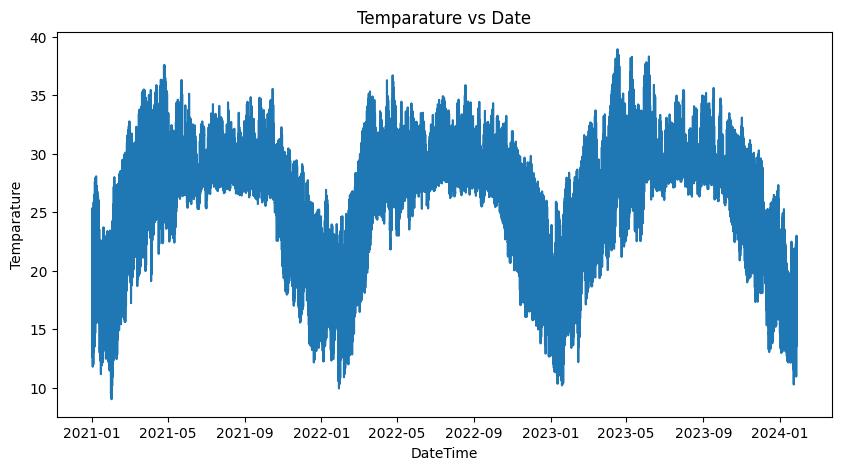

In [8]:
t2m = test1.extract_by_avering('t2m')
plt.figure(figsize=(10,  5))
plt.plot(t2m['Date'], t2m['t2m'])
plt.title('Temparature vs Date')
plt.xlabel('DateTime')
plt.ylabel('Temparature')

In [61]:
# n = 3050
# df_21_24[n:n+5]

Text(0, 0.5, 'Evaporation')

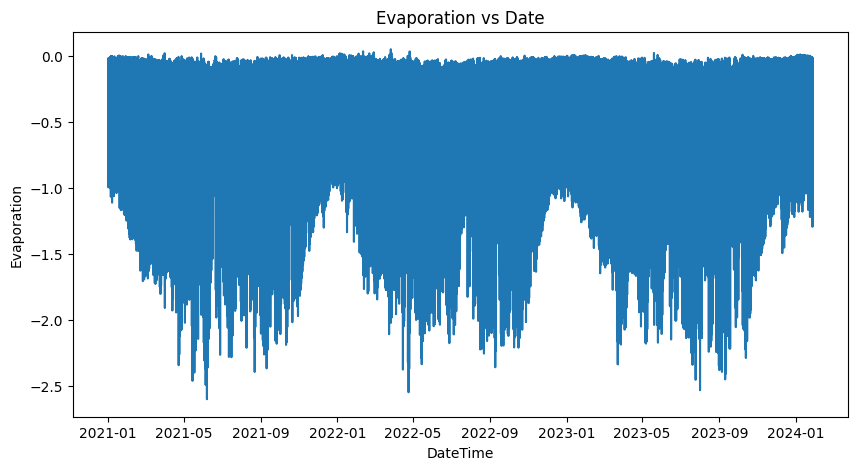

In [6]:
# plt.figure(figsize=(10,  5))
# plt.plot(df_21_24['Date'], df_21_24['Subbasin-1'])
# plt.title('Precipitation vs Date')
# plt.xlabel('DateTime')
# plt.ylabel('Precipitation')

# start_date = '2021-01-01 00:00:00'
# end_date = '2022-01-01 00:00:00'
# filtered_df = df_21_24[(df_21_24['Date'] >= start_date) & (df_21_24['Date'] <= end_date)]
plt.figure(figsize=(10,  5))
plt.plot(df_21_24['Date'], df_21_24['Subbasin-1'])
plt.title('Evaporation vs Date')
plt.xlabel('DateTime')
plt.ylabel('Evaporation')

In [11]:
df = pd.concat([df_1, df_2], ignore_index=True)


start_date = '2019-01-01 00:00:00'
end_date = '2022-01-01 00:00:00'
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
# filtered_df


with pd.ExcelWriter('output.xlsx', mode='w') as writer:
    filtered_df.to_excel(writer, sheet_name='tp', index=False)

,Date,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11
17520,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17521,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17522,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17523,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17524,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43820,2021-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43821,2021-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43822,2021-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43823,2021-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
